In [1]:
import os
import yaml
from itertools import groupby

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class ScipioYaml(dict):
    def __init__(self, yaml_file):
        data = yaml.load(open(yaml_file), Loader=yaml.SafeLoader)[0]
        for key in data:
            self[key] = data[key]
    
    def get_matches(self):
        for match in self['matchings']:
            yield match
    
    def intron_positions(self):
        info     = lambda x: (x['prot_start']+1, x['prot_end'], x['translation'], len(x['seq']))
        exons    = list(map(info, filter(lambda x: x['type']=='exon', self.get_matches())))
        position = np.array([(i[1], j[0]) for i, j in zip(exons,exons[1:])]) - self['prot_start']
        phase    = np.cumsum(np.array([i[3] for i in exons[:-1]]))%3
        
        if any(1 + position[:,0] != position[:,1]):
            return None
        
        if any([len(k)!=1+j-i for i, j, k, l in exons]):
            return None
        
        return position, phase

class A3M_map:
    def __init__(self, a3m_seq):
        self.a3m_seq = a3m_seq
        self.rmap    = self._map_positions(a3m_seq)
        return
    
    def _map_positions(self, a3m_seq):
        is_ins  = lambda x: x.islower()
        is_del  = lambda x: x=='-'
        now_ins = True
        now_del = True
        was_ins = True
        was_del = True
        seq_pos = 0.0
        aln_pos = 0.5
        seq_aln = []
        
        for x in a3m_seq:
            now_ins = is_ins(x)
            now_del = is_del(x)
            if was_ins:
                if now_ins:
                    seq_pos += 1.0
                elif now_del:
                    aln_pos += 0.5
                    seq_pos += 0.5
                else:
                    aln_pos += 0.5
                    seq_pos += 1.0
            elif was_del:
                if now_ins:
                    aln_pos += 0.5
                    seq_pos += 0.5
                elif now_del:
                    aln_pos += 1.0
                else:
                    aln_pos += 1.0
                    seq_pos += 0.5
            else:
                if now_ins:
                    aln_pos += 0.5
                    seq_pos += 1.0
                elif now_del:
                    aln_pos += 1.0
                    seq_pos += 0.5
                else:
                    aln_pos += 1.0
                    seq_pos += 1.0
            was_ins = now_ins  
            was_del = now_del
            seq_aln += [(x, aln_pos, seq_pos)]
        return np.array(seq_aln, dtype=object)

    def seq2aln(self, seq_pos):
        # actual sequence position to alignment position
        try:
            self._seq2aln
        except:
            self._seq2aln = {int(k): j for i, j, k in self.rmap if k%1!=0.5}
        return self._seq2aln[seq_pos]

    def index2aln(self, index):
        # index is the sequence index (relative to original sequence)
        try:
            self._index2aln
        except:
            self._index2aln = {int(k)-1: j for i, j, k in self.rmap if k%1!=0.5}
        return self._index2aln[index]

def draw_ss(ss, x, ypos=0.5, height=.2):
    for s, p in zip(ss, x):
        if s=='S': # blue
            pat=patches.Rectangle(width=1,height=height,fc='#0000ff',lw=0,xy=(p-0.5, ypos))
        if s=='H': # red
            pat=patches.Rectangle(width=1,height=height,fc='#ff0000',lw=0,xy=(p-0.5, ypos))
        if s=='L': # black
            pat=patches.Rectangle(width=1,height=height/4,fc='#000000',lw=0, xy=(p-0.5,ypos+(height*(3/8))))
        if s=='-': # black
            pat=patches.Rectangle(width=1,height=height/4,fc='#ffffff',lw=0, xy=(p-0.5,ypos+(height*(3/8))))
        plt.gca().add_patch(pat)
        del pat

def read_a3m(file):
    is_head = lambda x: x.startswith('>')
    parse_h = lambda x: tuple(x)[-1].strip()[1:]
    parse_s = lambda x: ''.join(j for i in x for j in i if j!='.' and not j.isspace())
    it      = iter(groupby(open(file), is_head))
    it      = iter(groupby(open(file), is_head)) if next(it)[0] else it
    for k, g in it:
        if k:
            h = parse_h(g)
        else:
            yield h, parse_s(g)


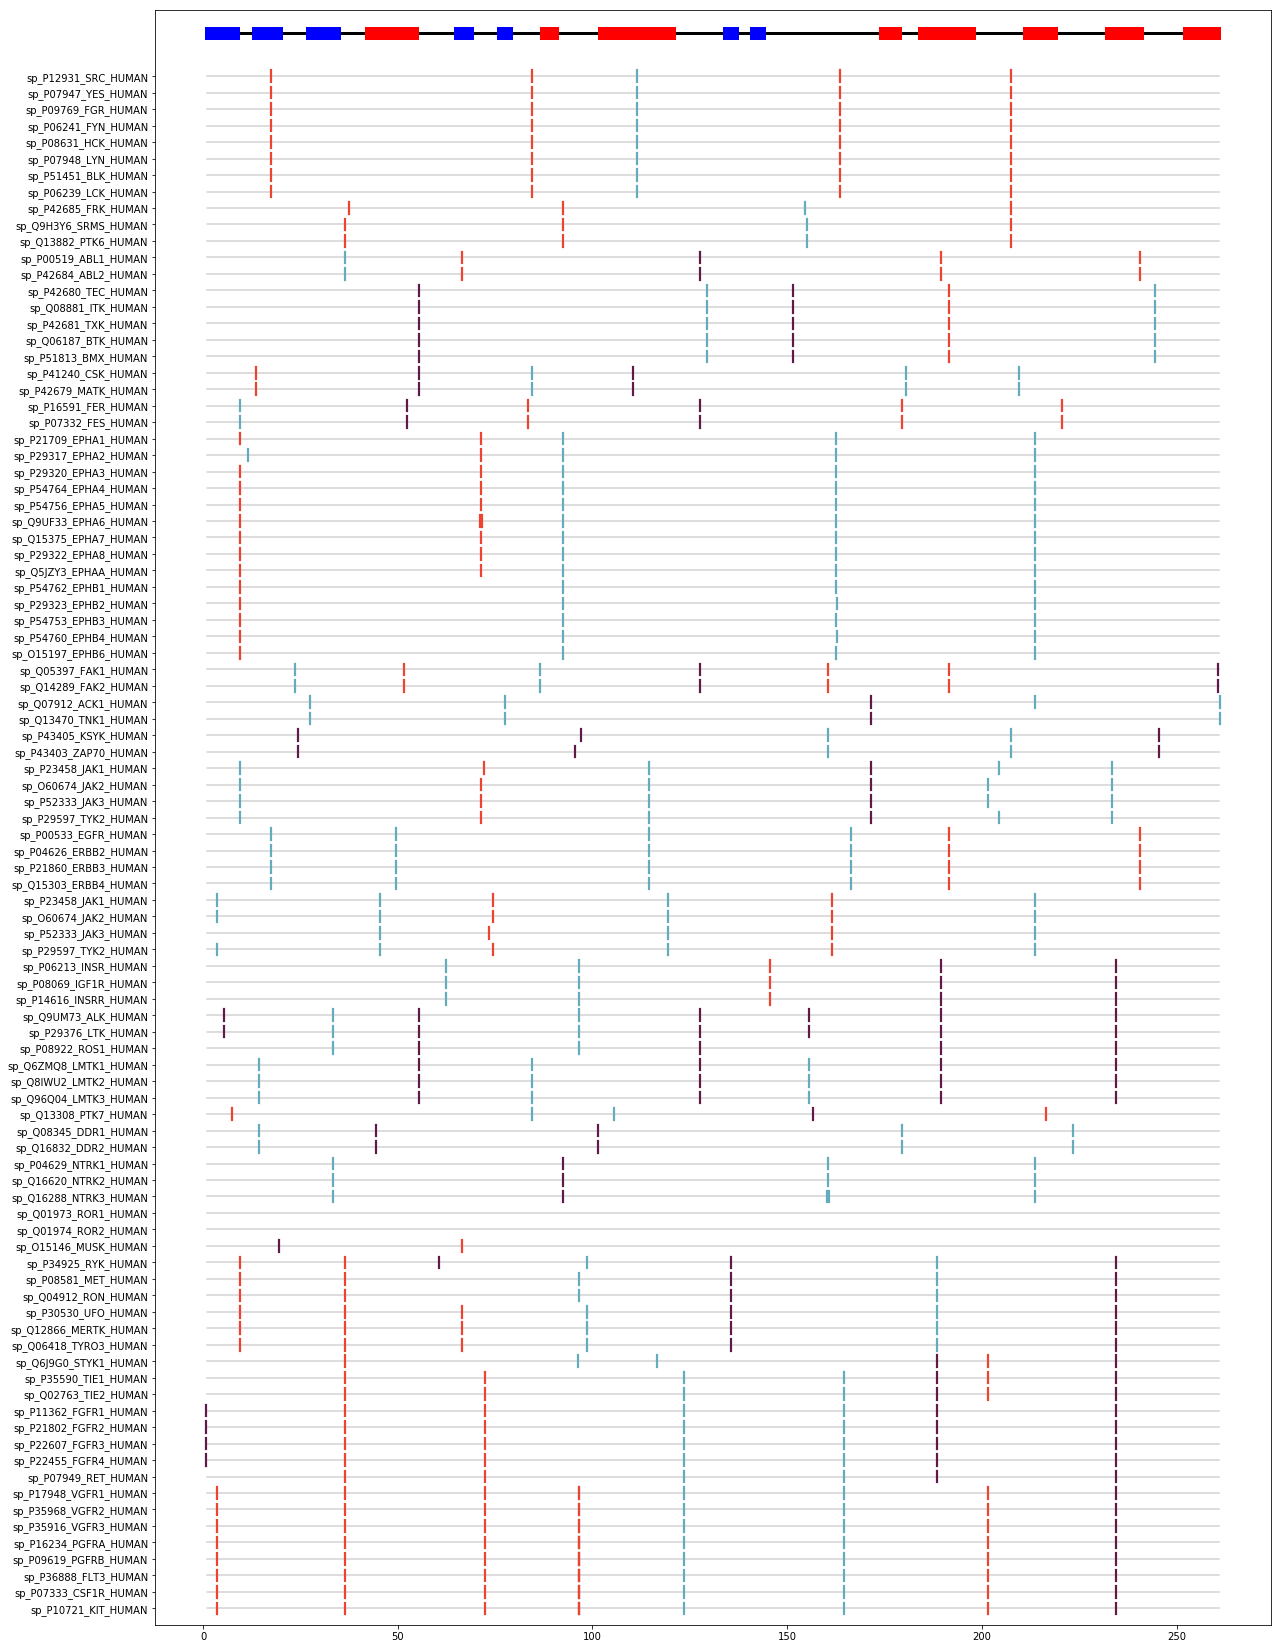

In [2]:
a3m_file  = 'data/human_tk261.a3m'
yaml_dir  = 'data/orf/'
max_pos   = 261
is_inside = lambda x: x > 0.5 and x < max_pos + 0.5

yticks      = [0]
yticklabels = ['']
lines       = []
for name, sequence in read_a3m(a3m_file):
    yaml_file = f'{yaml_dir}/{name}.yaml'
    data      = ScipioYaml(yaml_file).intron_positions()
    if data   == None: continue
        
    seq_map   = A3M_map(sequence)
    sites     = np.array([sum(map(seq_map.seq2aln,i))/2 for i in data[0]])

    ycoord       = yticks[-1] + 1
    yticks      += [ycoord]
    yticklabels += [name]
    lines       += [((1,261),(ycoord,ycoord),{'c':'lightgrey'})]
    
    for xpos, phase in zip(sites,data[1]):
        if not is_inside(xpos): continue
        color  = '#63ACBE' if phase==0 else '#EE442F' if phase==1 else '#601A4A' if phase==2 else 'black'
        lines += [((xpos,xpos), (ycoord+0.35,ycoord-0.35), {'c':color,'lw':2.2})]
    
plt.figure(figsize=(20, 0.3*(len(yticks)+4)))
plt.yticks(yticks[1:], yticklabels[1:])
plt.ylim(max(yticks)+1, min(yticks)-3)
for x, y, args in lines:
    plt.plot(x, y, **args)

ss = """
SSSSSSSSSLLLSSSSSSSSLLLLLLSSSSSSSSSLLLLLLHHHHHHHHHHHHHHLLLLLLLLLSSSSS
LLLLLLSSSSLLLLLLLHHHHHLLLLLLLLLLHHHHHHHHHHHHHHHHHHHHLLLLLLLLLLLLSSSSL
LLSSSSLLLLLLLLLLLLLLLLLLLLLLLLLLLLLHHHHHHLLLLHHHHHHHHHHHHHHHLLLLLLLLL
LLLHHHHHHHHHLLLLLLLLLLLLHHHHHHHHHHLLLLLLLLLLHHHHHHHHHH""".replace('\n','')
draw_ss(ss, 1+np.arange(len(ss)), ypos=-2, height=.8)

plt.show()